In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src/')
import plotutils

In [3]:
import fitbit
import os
import getpass
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

## Register your application

To get client ID and secret, register a personal application at www.dev.fitbit.com. See `img/register_app.png` for settings I used.

IMPORTANT: The callback url in `src/generate_tokens.py` and in the application settings must match exactly. Even a missing trailing forward slash `/` will result connection error!

In [31]:
os.environ['client_id'] = getpass.getpass('Enter client ID:')
os.environ['client_secret'] = getpass.getpass('Enter client secret:')

Enter client ID:········
Enter client secret:········


Modify the shell command below to use the fitbit python environment and run the `gengerate_tokens.py` script. This script takes in the client ID and secret as input and produces the access token files in `../data/`.

In [5]:
!/Users/hasannagib/opt/anaconda3/envs/fitbit/bin/python ../src/generate_tokens.py $client_id $client_secret

[31/Oct/2019:17:27:19] ENGINE Listening for SIGTERM.
[31/Oct/2019:17:27:19] ENGINE Listening for SIGHUP.
[31/Oct/2019:17:27:19] ENGINE Listening for SIGUSR1.
[31/Oct/2019:17:27:19] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[31/Oct/2019:17:27:19] ENGINE Started monitor thread 'Autoreloader'.
[31/Oct/2019:17:27:19] ENGINE Serving on http://127.0.0.1:8080
[31/Oct/2019:17:27:19] ENGINE Bus STARTED
127.0.0.1 - - [31/Oct/2019:17:27:38] "GET /?code=33ae15417578072348b1f20c714f9cb396a3ccf3&state=5ifpRO7S3bUj9b8FxMlE7oIPzF7HS3 HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.70 Safari/537.36"
[31/Oct/2019:17:27:39] ENGINE Bus STOPPING
[31/Oct/2019:17:27:39] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[31/Oct/2019:17:27:39] ENGINE Stopped thread 'Autoreloader'.
[31/Oct/2019:17:27:39] ENGINE Bus STOPPED
[31/Oct/2019:17:27:39] ENGIN

## Read tokens

In [9]:
with open('../data/access_token.txt','r') as f:
    os.environ['fitbit_access_token'] = f.read()

with open('../data/refresh_token.txt','r') as f:
    os.environ['fitbit_refresh_token'] = f.read()

## Login to Fitbit

In [10]:
auth_client = fitbit.Fitbit(
    os.environ['client_id'], 
    os.environ['client_secret'],
    os.environ['fitbit_access_token'],
    os.environ['fitbit_refresh_token']
)

## Query sleep data for a date

The `.get_sleep()` method gets sleep data for a given given date. 

In [11]:
sleep = auth_client.get_sleep(pd.to_datetime('2019-10-30'))['summary']['stages']

In [12]:
plotutils.sleep_summary_plot(sleep)

## Query sleep data over a date range

Fitbit limits user to 120 API calls per hour. So `.get_sleep()` wouldn't be ideal for getting sleep data over a longer period. Instead we can use the `.time_series()` which is an interface for [this](https://dev.fitbit.com/build/reference/web-api/sleep/#get-sleep-logs-by-date-range) date range API. 

This, however, only allows 100 data points to be extracted at a time. So in order to get more than 100 days worth of sleep data, we would have to split up our date range in chunks that are less than or equal to 100. 

In [13]:
# Split up date range into smaller chunks
dates = pd.date_range('2018-09-01','2019-10-30')
date_splits = np.array_split(dates, np.ceil(len(dates)/100))
date_splits_endpoints = [(date_split[0], date_split[-1]) for date_split in date_splits]

date_splits_endpoints

[(Timestamp('2018-09-01 00:00:00', freq='D'),
  Timestamp('2018-11-24 00:00:00', freq='D')),
 (Timestamp('2018-11-25 00:00:00', freq='D'),
  Timestamp('2019-02-17 00:00:00', freq='D')),
 (Timestamp('2019-02-18 00:00:00', freq='D'),
  Timestamp('2019-05-13 00:00:00', freq='D')),
 (Timestamp('2019-05-14 00:00:00', freq='D'),
  Timestamp('2019-08-06 00:00:00', freq='D')),
 (Timestamp('2019-08-07 00:00:00', freq='D'),
  Timestamp('2019-10-30 00:00:00', freq='D'))]

In [14]:
# Pull sleep data for each split
sleep = []
for endpoint in date_splits_endpoints:
    sleep += auth_client.time_series(
        resource='sleep',
        base_date=endpoint[0],
        end_date=endpoint[-1]
    )['sleep']

Here is what the API call output looks like: 

```json
{
    "sleep": [
        {
            "dateOfSleep": "2017-04-02",
            "duration": <value in milliseconds>,
            "efficiency": <value>,
            "isMainSleep": <true|false>,
            "levels": {
                "summary": {
                    "deep": {
                        "count": <value>,
                        "minutes": <value>,
                        "thirtyDayAvgMinutes": <value>
                    },
                    "light": {
                        "count": <value>,
                        "minutes": <value>,
                        "thirtyDayAvgMinutes": <value>
                    },
                    "rem": {
                        "count": <value>,
                        "minutes": <value>,
                        "thirtyDayAvgMinutes": <value>
                    },
                    "wake": {
                        "count": <value>,
                        "minutes": <value>,
                        "thirtyDayAvgMinutes": <value>
                    }
                },
                "data": [
                    {
                        "datetime": "2017-04-01T23:58:30.000",
                        "level": "wake",
                        "seconds": <value>
                    },
                    {
                        "datetime": "2017-04-02T00:16:30.000",
                        "level": "light",
                        "seconds": <value>
                    },
                    <...>
                ],
                "shortData": [
                    {
                        "datetime": "2017-04-02T05:58:30.000",
                        "level": "wake",
                        "seconds": <value>
                    },
                    <...>
                ]
            },
            "logId": <value>,
            "minutesAfterWakeup": <value>,
            "minutesAsleep": <value>,
            "minutesAwake": <value>,
            "minutesToFallAsleep": <value>, // this is generally 0 for autosleep created sleep logs
            "startTime": "2017-04-01T23:58:30.000",
            "timeInBed": <value in minutes>,
            "type": "stages"
        },
        <...>
    ]
}

```

Let's parse some of the data from this and store in a dataframe

In [16]:
# Parse sleep data range API output 
items = ['timeInBed', 'minutesAsleep', 'dateOfSleep']
sleep_data = [{item:s[item] for item in items} for s in sleep]

In [22]:
# Create dataframe 
df = pd.DataFrame(sleep_data)
df['dateOfSleep'] = pd.to_datetime(df['dateOfSleep'])
df = df.sort_values('dateOfSleep').reset_index()

## `matplotlib`

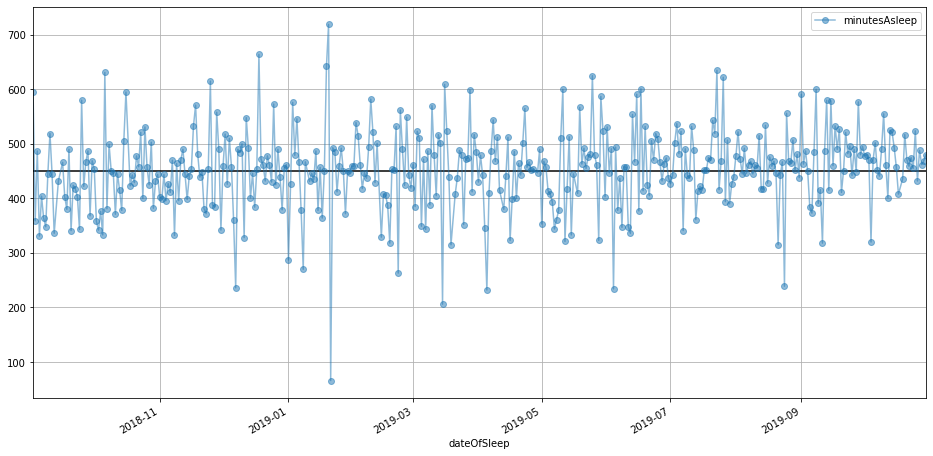

In [23]:
df_plot = df.groupby(pd.Grouper(key='dateOfSleep', freq='d')).sum().query('minutesAsleep > 0')

df_plot['minutesAsleep'].plot(
    figsize=(16,8),
    grid=True,
    style='o-',
    alpha=0.5
);

plt.hlines(450, df_plot.index.min(), df_plot.index.max())
plt.legend();

## `bokeh`

In [28]:
df_plot['Goal'] = 7.5*60
plotutils.plot_ts(
    df_plot, 
    ys=['minutesAsleep', 'Goal'], 
    hover_vars=['timeInBed', 'index'],
    styles=['o-', '-'],
    plot_height=300,
    plot_width=800
)